Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
# importing all required libraries for visualize, process and build the model

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Importing Skin Cancer Data

In [2]:
# ## If you are using the data by mounting the google drive, use the following :
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

# loading the data from the local
train_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [4]:
# printing the number of images available in test and training dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'Image count in training dataset {image_count_train}')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'Image count in testing dataset {image_count_test}')

Image count in training dataset 2239
Image count in testing dataset 118


**Motivation:** To create a multiclass classification model using a custom convolutional neural network in tensorflow

**Data Summary:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

*   Actinic keratosis
*   Basal cell carcinoma
*   Dermatofibroma
*   Melanoma
*   Nevus
*   Seborrheic keratosis
*   Squamous cell carcinoma
*   Pigmented benign keratosis
*   Vascular lesion





### Create a dataset

Define parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# ## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


We can observe the 9 classes in above output

### Visualize the data

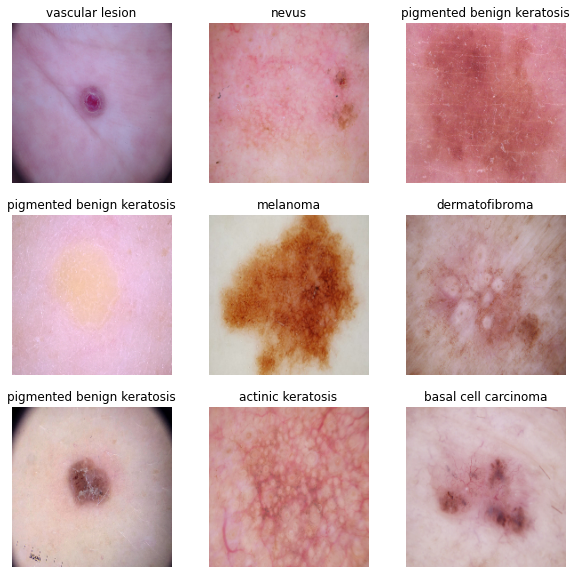

In [9]:
# Ploting the 9 types of skin cancer
# setting the output figure size
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(50, 180, 180, 3)`. This is a batch of 50 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(50,)`, these are corresponding labels to the 50 images.



`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
#Standardize Data of RGB channel value
# normalization_layer = layers.Rescaling(1./255)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.1581701 0.7686275


In [12]:
# getting the number of classes in the dataset
num_classes = len(class_names)

# building the model with keras Sequential with relu as activation function
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [13]:
#using adam for optimizer and SparseCategoricalCrossentropy as loss function to compute crossentropy loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
# Training the model with epochs as 20
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 414ms/step - loss: 2.0789 - accuracy: 0.2427 - val_loss: 1.9116 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 22s 401ms/step - loss: 1.7330 - accuracy: 0.3705 - val_loss: 1.5392 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 23s 405ms/step - loss: 1.5297 - accuracy: 0.4609 - val_loss: 1.5876 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 23s 413ms/step - loss: 1.3697 - accuracy: 0.5229 - val_loss: 1.4459 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 23s 404ms/step - loss: 1.2852 - accuracy: 0.5419 - val_loss: 1.5282 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 22s 398ms/step - loss: 1.2063 - accuracy: 0.5698 - val_loss: 1.5167 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 22s 402ms/step - loss: 1.1662 - accuracy: 0.5804 - val_loss: 1.3667 - val_accuracy: 0.5302

We can observe that,

      Training Loss       : ~0.36
      Validation Loss     : 2.76
      Training Accuracy   : ~0.87
      Validation Accuracy : 0.51

We can see that there is a significant increase in Loss and decrease in accuracy

### Visualizing training results
Now let's visualize the results from the model

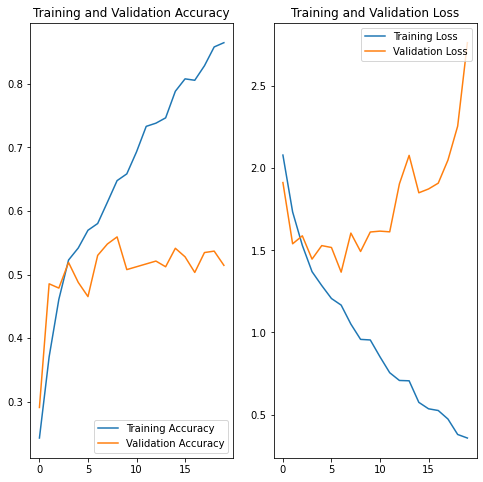

In [16]:
# storing model accuracy in acc
acc = history.history['accuracy']
# storing model vavalidation accuracy in val_acc
val_acc = history.history['val_accuracy']
# storing the model loss in loss variable
loss = history.history['loss']
# storing validation loss of model in val_loss variable
val_loss = history.history['val_loss']

# taking the range using the epochs
epochs_range = range(epochs)

# setting the output figure size
plt.figure(figsize=(8, 8))
# plotting the training and validation accuracy in 1st plot
# setting the properties for the 1st image in the output image
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# setting the legend possition in the image
plt.legend(loc='lower right')
# setting the image title
plt.title('Training and Validation Accuracy')

# plotting the training and validation loss in 2nd plot
# setting the properties for the 2nd image in the output image
plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# setting the legend possition in the image
plt.legend(loc='upper right')
# setting the image title
plt.title('Training and Validation Loss')
# printing the plot
plt.show()

### Findings
* Validation accuracy is significantly dropped towards right-side of the plot
* Validation accuracy is slightly higher in the initial stage
* Validation Loss is very high compare to training loss towards right-side of the plot
* Validation loss is slightly low compare to training loss in the left-side/initial stage

Based on above findings, we can say that the model is **overfitting**

In [17]:
# As the model is overfitting, lets due the agumentation to reduce the overfitting
# Let's use random flip, rotate and zoom for agumentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)])

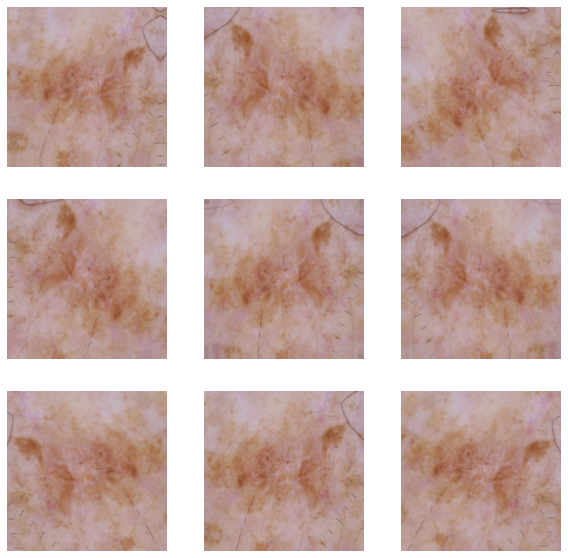

In [18]:
#visualize how your augmentation strategy works for one instance of training image.
# setting the output image size
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Let's add some dropout layers to the model as our model is overfitting
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [20]:
## compiling the model with adam optinizer and crossentropy for loss function and accuracy as metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# printing the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
# We are not changing the epochs count for the second model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 477ms/step - loss: 2.0646 - accuracy: 0.2539 - val_loss: 1.8357 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 25s 455ms/step - loss: 1.8281 - accuracy: 0.3248 - val_loss: 1.7000 - val_accuracy: 0.3669
Epoch 3/20
56/56 [==============================] - 26s 460ms/step - loss: 1.6272 - accuracy: 0.4219 - val_loss: 1.6983 - val_accuracy: 0.4206
Epoch 4/20
56/56 [==============================] - 26s 463ms/step - loss: 1.5730 - accuracy: 0.4509 - val_loss: 1.5610 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 26s 461ms/step - loss: 1.4405 - accuracy: 0.5050 - val_loss: 1.4164 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 26s 473ms/step - loss: 1.3827 - accuracy: 0.5028 - val_loss: 1.3701 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 26s 461ms/step - loss: 1.3514 - accuracy: 0.5173 - val_loss: 1.4057 - val_accuracy: 0.5280

We can observe that,

      Training Loss       : ~1.09
      Validation Loss     : 1.43
      Training Accuracy   : ~60%
      Validation Accuracy : 54%

### Visualizing the results

Let's visualize the results to see how the model behaving

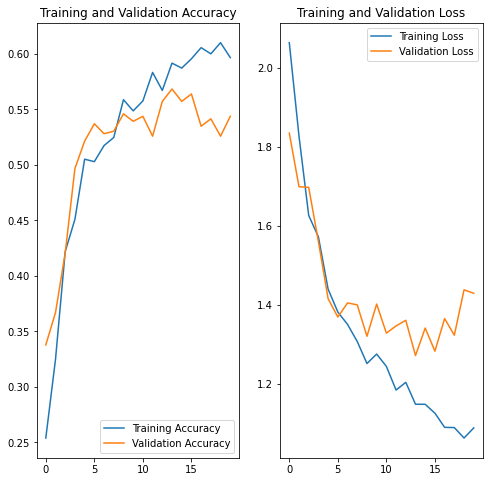

In [22]:
# storing model accuracy in acc
acc = history.history['accuracy']
# storing model vavalidation accuracy in val_acc
val_acc = history.history['val_accuracy']
# storing the model loss in loss variable
loss = history.history['loss']
# storing validation loss of model in val_loss variable
val_loss = history.history['val_loss']

# taking the range using the epochs
epochs_range = range(epochs)

# setting the output figure size
plt.figure(figsize=(8, 8))
# plotting the training and validation accuracy in 1st plot
# setting the properties for the 1st image in the output image
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# setting the legend possition in the image
plt.legend(loc='lower right')
# setting the image title
plt.title('Training and Validation Accuracy')

# plotting the training and validation loss in 2nd plot
# setting the properties for the 2nd image in the output image
plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# setting the legend possition in the image
plt.legend(loc='upper right')
# setting the image title
plt.title('Training and Validation Loss')
# printing the plot
plt.show()

#### Findings
* Training and validation accuracy are following the same trend, but there are some spike up & down in validation accuracy
* We can observe the same behavior in the Validation and Training loss, where Validation loss is following the same tread as training loss and there are spikes in the loss
* there is some distortion in the validation results compare to training results, this might be caused by class imbalance

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

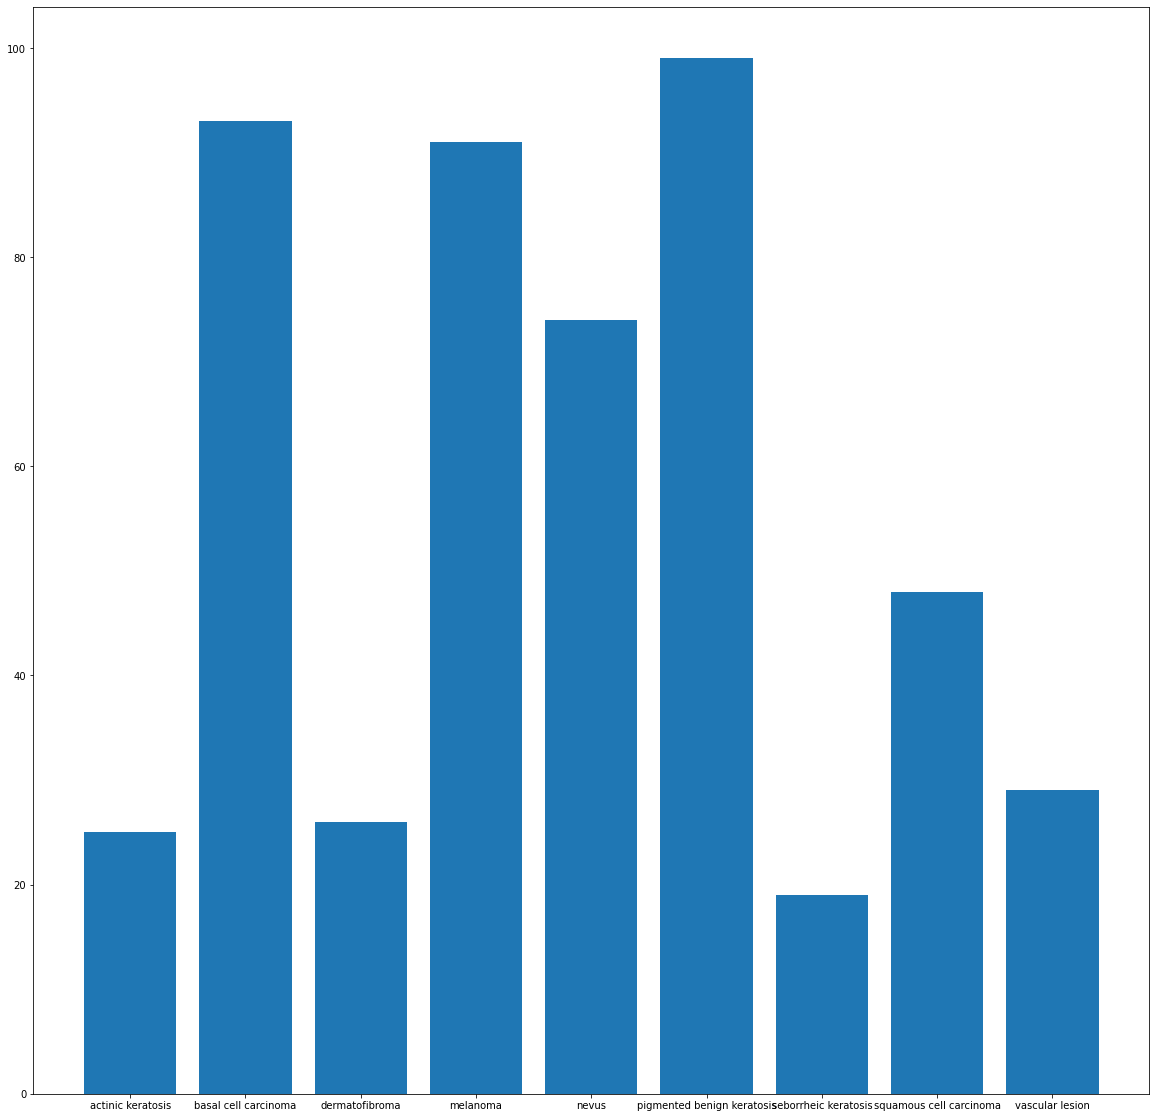

In [23]:
# Let's check on the Class Imbalance if Present
# taking empty dictionary
class_data = dict()

# adding the empty lists for each class record in the dictionary
for i in class_names:
  class_data[i] = []

# setting the output image size
plt.figure(figsize=(10, 10))
# adding the images into the data dictionary for each class
for images, labels in train_ds:
  for i in range(9):
    class_data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))
# storing the number of images for specific class
for i in class_data:
  # getting the length and storing the dictionary
  class_data[i] = len(class_data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
# printing the plot
plt.bar(range(len(class_data)), list(class_data.values()), align='center')
plt.xticks(range(len(class_data)), list(class_data.keys()))
plt.show()

#### Findings 
* `Seborrheic keratosis` have less data compare to remaining classes
* `Pigmented Benign Keratosis` classes have more records in the dataset compare to other classes


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
# installing the Agumentor
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
# importing the agumentor package 
import Augmentor

# taking the Training dataset path
# path_to_training_dataset='gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

for i in class_names:
  # instantiating the pipeline object with training dataset for a specific class
    p = Augmentor.Pipeline(train_path + i)
    # rotating the image
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # We are adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500) 

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2208DAA5DF0>:   1%| | 5/500 [00:00<01:10,  6.99 Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22090CCA880>: 100%|█| 500/500 [00:04<00:00, 121.39 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x22090CF8E20>:   3%| | 13/500 [00:00<00:1

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2208EAB7220>: 100%|█| 500/500 [00:04<00:00, 124.72 Samples
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x22090F70EB0>:   1%| | 3/500 [00:00<01:19,  6.25 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2208EE4FFD0>: 100%|█| 500/500 [00:04<00:00, 116.82 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x22090CFD940>: 100%|█| 500/500 [00:20<00:00, 24.10 Sample
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x22090CC2BE0>:   0%| | 1/500 [00:00<01:15

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=962x722 at 0x2208D5BCAC0>: 100%|█| 500/500 [00:19<00:00, 25.10 Samples/
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2208EAB7460>:   1%| | 7/500 [00:00<00:08

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2208D1E46D0>: 100%|█| 500/500 [00:04<00:00, 111.41 Samples
Executing Pipeline:   0%|                                                                | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2208D745580>: 100%|█| 500/500 [00:10<00:00, 47.27 Samples
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2208D353B80>:   2%| | 12/500 [00:00<00:5

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x220D467F340>: 100%|█| 500/500 [00:04<00:
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x220D4651790>:   2%| | 10/500 [00:00<00:54,  9.01 Samples/s

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2208D8DBE80>: 100%|█| 500/500 [00:04<00:00, 113.20 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
# again printing the image count in training dataset
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(f'Number of images in training dataset: {image_count_train}')

Number of images in training dataset: 4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [27]:
# importing glob to find files recursively
from glob import glob

In [28]:
# generating path list
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

4500

In [29]:
# taking the skin cancer type in a list
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [30]:
# creating a new dictionary with the file path and class type
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
# creating a dataframe with the above dictionary
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2
# new_df = original_df.append(df2)

In [32]:
# printing the number of images under each type
new_df['Label'].value_counts()

seborrheic keratosis          500
dermatofibroma                500
squamous cell carcinoma       500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
actinic keratosis             500
vascular lesion               500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

#### Create a training dataset

In [33]:
# creating the training dataset to training the model
# data_dir_train='gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [34]:
# creating validation dataset to check the model
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [35]:
# performing autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#normalizing the Data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# creating a model post handling the imbalancing
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

0.07908502 0.88676476


#### Compile your model (Choose optimizer and loss function appropriately)

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### Train your model

In [37]:
# lets train the model with 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 82s 481ms/step - loss: 2.0473 - accuracy: 0.2353 - val_loss: 1.6507 - val_accuracy: 0.3578
Epoch 2/30
169/169 [==============================] - 79s 467ms/step - loss: 1.6057 - accuracy: 0.3893 - val_loss: 1.5046 - val_accuracy: 0.4491
Epoch 3/30
169/169 [==============================] - 80s 475ms/step - loss: 1.4928 - accuracy: 0.4290 - val_loss: 1.3865 - val_accuracy: 0.4796
Epoch 4/30
169/169 [==============================] - 80s 474ms/step - loss: 1.3948 - accuracy: 0.4681 - val_loss: 1.2958 - val_accuracy: 0.4974
Epoch 5/30
169/169 [==============================] - 80s 474ms/step - loss: 1.2874 - accuracy: 0.5171 - val_loss: 1.2552 - val_accuracy: 0.5330
Epoch 6/30
169/169 [==============================] - 79s 465ms/step - loss: 1.2534 - accuracy: 0.5261 - val_loss: 1.1814 - val_accuracy: 0.5330
Epoch 7/30
169/169 [==============================] - 79s 467ms/step - loss: 1.2059 - accuracy: 0.5432 - val_loss: 1.4313 - val_ac

We can observe that the Validation loss and training loss is near values as well as training and validation accuracy also near values

#### **Todo:**  Visualize the model results

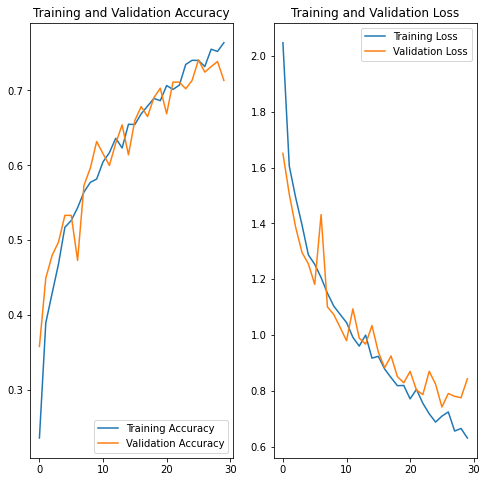

In [38]:
# storing model accuracy in acc
acc = history.history['accuracy']
# storing model vavalidation accuracy in val_acc
val_acc = history.history['val_accuracy']
# storing the model loss in loss variable
loss = history.history['loss']
# storing validation loss of model in val_loss variable
val_loss = history.history['val_loss']

# taking the range using the epochs
epochs_range = range(epochs)

# setting the output figure size
plt.figure(figsize=(8, 8))
# plotting the training and validation accuracy in 1st plot
# setting the properties for the 1st image in the output image
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# setting the legend possition in the image
plt.legend(loc='lower right')
# setting the image title
plt.title('Training and Validation Accuracy')

# plotting the training and validation loss in 2nd plot
# setting the properties for the 2nd image in the output image
plt.subplot(1, 2, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# setting the legend possition in the image
plt.legend(loc='upper right')
# setting the image title
plt.title('Training and Validation Loss')
# printing the plot
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Findings:
* We can observe that the training and validation accuracy are following the same trend in both Accuracy & Loss
* final model accuracy interms of training accuracy is `76%` & validation accuracy is `71%`